In [ ]:
!pip install wfdb

In [ ]:
!pip install neurokit2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import wfdb
import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
from scipy.signal import find_peaks
from scipy.signal import spectrogram

In [5]:
file_path = '/content/drive/MyDrive/ECG_data/s20011'

In [ ]:
record = wfdb.rdrecord(file_path)
ecg_signal = record.p_signal
ecg_frequency = record.fs
lead_number = 0
ecg_data = ecg_signal[:, lead_number]

segment_start = 0
segment_end = 0
end_time = len(ecg_data)
offset = 0
segments = []


while segment_end < end_time:
  print(segment_end // 250, end_time // 250)
  offset = segment_start
  if end_time - segment_start < ecg_frequency * 4:
      break

  segment_end = min(segment_start + 5 * 60 * ecg_frequency, end_time)
  current_segment = ecg_data[segment_start : segment_end]
  ecg_clean = nk.ecg_clean(current_segment, sampling_rate=250)

  _, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=ecg_frequency)
  _, waves_peak = nk.ecg_delineate(ecg_clean, rpeaks, sampling_rate=ecg_frequency)
  P_onset = waves_peak["ECG_P_Onsets"]
  R_peaks = rpeaks['ECG_R_Peaks']
  T_peaks = waves_peak['ECG_T_Peaks']
  T_offset = waves_peak["ECG_T_Offsets"]


  for p_onset, r_peak, t_peak, t_offset in zip(P_onset, R_peaks, T_peaks, T_offset):
    if (not np.isnan(r_peak)) and (not np.isnan(t_peak)) and (not np.isnan(p_onset)) and (not np.isnan(t_offset)):
      segment = ecg_clean[p_onset : t_offset]

      padding_length = 256 - len(segment)
      if (len(segment) > 256):
        print('oi')
        continue
      padded_segment = np.pad(segment, (0, padding_length), mode='constant')

      segments.append(padded_segment)
      segment_start = t_peak + offset
  if segment_start == offset:
    segment_start = segment_end

In [10]:
average_segments = []


for i in range(0, len(segments), 10):
  segment_part = []
  for x in segments[i : i + 10]:
    segment_part.append(x)

  av_segment = np.sum(segment_part, axis=0) / 10
  average_segments.append(av_segment)
  plt.figure(figsize=(10, 6))
  for seg in segment_part:
    plt.plot(seg, color='lightgrey', alpha=0.5)
  plt.plot(av_segment, color='blue', linewidth=2, label='Средний удар')
  plt.title('Усредненный сигнал ЭКГ')
  plt.show()
  break

In [ ]:
average_segments = []


for i in range(0, len(segments), 10):
  segment_part = []
  for x in segments[i : i + 10]:
    segment_part.append(x)

  av_segment = np.sum(segment_part, axis=0) / len(segment_part)
  average_segments.append(av_segment)

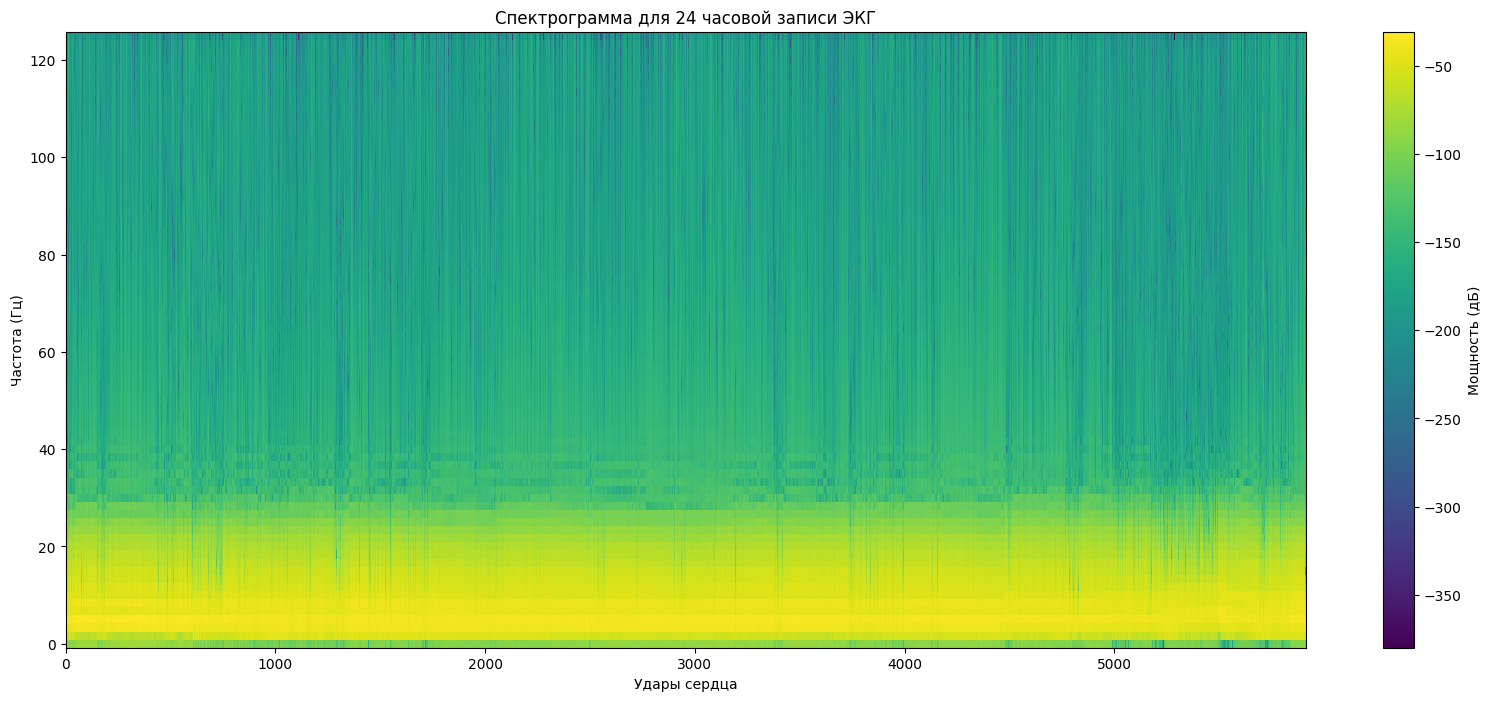

In [ ]:
# Объединяем все дополненные кусочки сигнала ЭКГ в один массив
combined_segments = np.concatenate(average_segments)

# Вычисляем спектрограмму для объединенного массива
f, t, Sxx = spectrogram(combined_segments, fs=ecg_frequency, nperseg=150, noverlap = 0)

# Отображаем спектрограмму
plt.figure(figsize=(20, 8))
plt.pcolormesh(t, f, 10 * np.log(Sxx))
plt.colorbar(label='Мощность (дБ)')
plt.ylabel('Частота (Гц)')
plt.xlabel(f'Удары сердца')
plt.title('Спектрограмма для 24 часовой записи ЭКГ')
#plt.ylim(0, 50)
plt.show()
